# Importing packages and data preparation

In [2]:
# system level
import sys
import json
import codecs
import os

# arrays
import numpy as np
from numpy import random
from scipy import interp

# keras
from keras import backend as K
from keras import models
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.layers import Input, Flatten, Dense, Activation, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

# sklearn (for machine learning)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss

# plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.patches as mpatches

# grad-CAM
from vis.visualization import visualize_cam
from vis.utils import utils

In [3]:
# ------------------------------------------------------------------------------
# Input variables
# ------------------------------------------------------------------------------

# training variables
# 70:10:20 for training:valid:test
nb_train = 10799
nb_valid = 1542
nb_test = 3085
nb_epoch = 500
nb_classes = 2
batch_size = 128
shuffle = True

# data locations
dir_test = "model/"
# pristine images
# for noisy images change SB00 to SB25 in all files that contain this part in their name
file_x_data = "SB00_augmented.npy" # x data (images)
file_y_data = "SB00_augmented_y.npy" # y data (labels) 

f_model = dir_test + "SB00_model.json" # model data (architecture)
f_history = dir_test + "SB00_history.json" # training history 
f_weights = dir_test + "SB00_weights.h5" # model data (final weights)
f_best_weights = dir_test + "SB00_best_weights.h5" # model data (best weights, give highest validation accuracy)

merg_sub = "subsamples_y.npy" # file which contains past and future merger subsample labels
subid_load = "subsamples_ID.npy" # file with all halo ID numbers in these subsamples, so we can keep track of the objects
cc_load = "concentration.npy" # concentration
m20_load = "m20.npy" # M20
logMstar_load = "logMstar.npy" # log(M_star/M_10)

In [4]:
# load data, all filters
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)

# load pre and postmerger subsamples id halo IDs for these subsamples
y_sub = np.load(merg_sub) # (merger-1/nonmerger-0, past merger-1/future merger-0, past merger-0/future merger-1)
subids = np.load(subid_load)

# load concentration, M20 and stellar mass LogM 
cc = np.load(cc_load)
m20 = np.load(m20_load)
logM = np.load(logMstar_load)

In [5]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------


#every day we shufflin
random.seed(5)
idx = np.random.choice(len(x_data), size=len(x_data), replace=False)
x_data = x_data[idx]
y_data = y_data[idx]
y_sub_data = y_sub[idx]
subid = subids[idx]
cc = cc[idx]
m20 = m20[idx]
logM = logM[idx]


# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# slice the subsample arrays
y_sub_train = y_sub_data[:ind_train_end]
y_sub_valid = y_sub_data[ind_valid_start: ind_valid_end]
y_sub_test = y_sub_data[ind_test_start: ind_test_end]

#slice subids
subid_train = subid[:ind_train_end]
subid_valid = subid[ind_valid_start: ind_valid_end]
subid_test = subid[ind_test_start: ind_test_end]

#slice cc
cc_train = cc[:ind_train_end]
cc_valid = cc[ind_valid_start: ind_valid_end]
cc_test = cc[ind_test_start: ind_test_end]

#slice m20
m20_train = m20[:ind_train_end]
m20_valid = m20[ind_valid_start: ind_valid_end]
m20_test = m20[ind_test_start: ind_test_end]

#slice LogM
logM_train = logM[:ind_train_end]
logM_valid = logM[ind_valid_start: ind_valid_end]
logM_test = logM[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')


print( "Data dimensions: ")
print( "Input data: ", np.shape(x_data), np.shape(y_data), "and subsample array:", np.shape(y_sub_data))
print( "Training set: ", np.shape(x_train), np.shape(y_train), "and subsample array:", np.shape(y_sub_train))
print( "Validation set: ", np.shape(x_valid), np.shape(y_valid),"and subsample array:", np.shape(y_sub_valid))
print( "Test Set: ", np.shape(x_test), np.shape(y_test), "and subsample array:", np.shape(y_sub_test))

print("Subid input",np.shape(subid),"Subid train:",np.shape(subid_train),"Subid validation:",np.shape(subid_valid),"Subid test:",np.shape(subid_test))

print("Concentration input",np.shape(cc),"CC train:",np.shape(cc_train),"CC validation:",np.shape(cc_valid),"CC test:",np.shape(cc_test))
print("M20 input",np.shape(m20),"M20 train:",np.shape(m20_train),"M20 validation:",np.shape(m20_valid),"M20 test:",np.shape(m20_test))
print("logM input",np.shape(logM),"logM train:",np.shape(logM_train),"logM validation:",np.shape(logM_valid),"logM test:",np.shape(logM_test))

Data dimensions: 
Input data:  (15426, 2, 75, 75) (15426,) and subsample array: (15426, 3)
Training set:  (10799, 2, 75, 75) (10799,) and subsample array: (10799, 3)
Validation set:  (1542, 2, 75, 75) (1542,) and subsample array: (1542, 3)
Test Set:  (3085, 2, 75, 75) (3085,) and subsample array: (3085, 3)
Subid input (15426,) Subid train: (10799,) Subid validation: (1542,) Subid test: (3085,)
Concentration input (15426,) CC train: (10799,) CC validation: (1542,) CC test: (3085,)
M20 input (15426,) M20 train: (10799,) M20 validation: (1542,) M20 test: (3085,)
logM input (15426,) logM train: (10799,) logM validation: (1542,) logM test: (3085,)


# Model training

In [8]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(x_data)
input_shape = (2, 75, 75)

x = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y = Dense(1, activation='sigmoid')(z1)

model = Model(inputs=x, outputs=y)

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 75, 75)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 75, 75)         408       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 75, 75)         300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 37, 37)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 37, 37)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 37, 37)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 37, 37)        148       
__________

In [6]:
# ------------------------------------------------------------------------------
# Train model
# Training is stopped by monitoring validation loss
# Best weights are saved, in order to maximize validation accuracy
# ------------------------------------------------------------------------------
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
     ModelCheckpoint(f_best_weights, monitor='val_acc', mode='max', verbose=1, save_best_only=True)]

# Train 
history = model.fit(
                    x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_valid, y_valid),                
                    shuffle=shuffle,
                    verbose=True,
                    callbacks=es
                    )

# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

#Saving history for future use
with open(f_history, 'w') as f:
    json.dump(history.history, f)

Train on 10799 samples, validate on 1542 samples
Epoch 1/500
10799/10799 [==============================] - 187s 17ms/step - loss: 0.6976 - acc: 0.5239 - val_loss: 0.6935 - val_acc: 0.5201

Epoch 00001: val_acc improved from -inf to 0.52010, saving model to model/SB0_best_weights_68_4_14.h5
Epoch 2/500
10799/10799 [==============================] - 200s 19ms/step - loss: 0.6915 - acc: 0.5239 - val_loss: 0.6905 - val_acc: 0.5201

Epoch 00002: val_acc did not improve from 0.52010
Epoch 3/500
10799/10799 [==============================] - 355s 33ms/step - loss: 0.6874 - acc: 0.5252 - val_loss: 0.6858 - val_acc: 0.5292

Epoch 00003: val_acc improved from 0.52010 to 0.52918, saving model to model/SB0_best_weights_68_4_14.h5
Epoch 4/500
10799/10799 [==============================] - 396s 37ms/step - loss: 0.6826 - acc: 0.6102 - val_loss: 0.6818 - val_acc: 0.6388

Epoch 00004: val_acc improved from 0.52918 to 0.63878, saving model to model/SB0_best_weights_68_4_14.h5
Epoch 5/500
10799/10799 [

10799/10799 [==============================] - 394s 36ms/step - loss: 0.5697 - acc: 0.7143 - val_loss: 0.5409 - val_acc: 0.7562

Epoch 00040: val_acc improved from 0.75357 to 0.75616, saving model to model/SB0_best_weights_68_4_14.h5
Epoch 41/500
10799/10799 [==============================] - 394s 36ms/step - loss: 0.5746 - acc: 0.7148 - val_loss: 0.5501 - val_acc: 0.7412

Epoch 00041: val_acc did not improve from 0.75616
Epoch 42/500
10799/10799 [==============================] - 394s 36ms/step - loss: 0.5731 - acc: 0.7136 - val_loss: 0.5418 - val_acc: 0.7458

Epoch 00042: val_acc did not improve from 0.75616
Epoch 43/500
10799/10799 [==============================] - 396s 37ms/step - loss: 0.5757 - acc: 0.7185 - val_loss: 0.6096 - val_acc: 0.6783

Epoch 00043: val_acc did not improve from 0.75616
Epoch 44/500
10799/10799 [==============================] - 394s 36ms/step - loss: 0.5757 - acc: 0.7168 - val_loss: 0.5422 - val_acc: 0.7490

Epoch 00044: val_acc did not improve from 0.7561

10799/10799 [==============================] - 297s 28ms/step - loss: 0.5252 - acc: 0.7542 - val_loss: 0.5021 - val_acc: 0.7672

Epoch 00122: val_acc did not improve from 0.78923
Epoch 123/500
10799/10799 [==============================] - 298s 28ms/step - loss: 0.5296 - acc: 0.7481 - val_loss: 0.5227 - val_acc: 0.7529

Epoch 00123: val_acc did not improve from 0.78923
Epoch 124/500
10799/10799 [==============================] - 296s 27ms/step - loss: 0.5199 - acc: 0.7548 - val_loss: 0.4970 - val_acc: 0.7795

Epoch 00124: val_acc did not improve from 0.78923
Epoch 125/500
10799/10799 [==============================] - 299s 28ms/step - loss: 0.5293 - acc: 0.7487 - val_loss: 0.4914 - val_acc: 0.7873

Epoch 00125: val_acc did not improve from 0.78923
Epoch 126/500
10799/10799 [==============================] - 298s 28ms/step - loss: 0.5246 - acc: 0.7516 - val_loss: 0.4937 - val_acc: 0.7776

Epoch 00126: val_acc did not improve from 0.78923
Epoch 127/500
10799/10799 [======================


Epoch 00205: val_acc did not improve from 0.80156
Epoch 206/500
10799/10799 [==============================] - 296s 27ms/step - loss: 0.4960 - acc: 0.7737 - val_loss: 0.4739 - val_acc: 0.7879

Epoch 00206: val_acc did not improve from 0.80156
Epoch 207/500
10799/10799 [==============================] - 295s 27ms/step - loss: 0.4861 - acc: 0.7772 - val_loss: 0.4584 - val_acc: 0.8093

Epoch 00207: val_acc improved from 0.80156 to 0.80934, saving model to model/SB0_best_weights_68_4_14.h5
Epoch 208/500
10799/10799 [==============================] - 297s 27ms/step - loss: 0.4876 - acc: 0.7810 - val_loss: 0.4575 - val_acc: 0.8087

Epoch 00208: val_acc did not improve from 0.80934
Epoch 209/500
10799/10799 [==============================] - 297s 28ms/step - loss: 0.4955 - acc: 0.7716 - val_loss: 0.4542 - val_acc: 0.7938

Epoch 00209: val_acc did not improve from 0.80934
Epoch 210/500
10799/10799 [==============================] - 300s 28ms/step - loss: 0.4906 - acc: 0.7781 - val_loss: 0.460


Epoch 00247: val_acc did not improve from 0.80934
Epoch 248/500
10799/10799 [==============================] - 411s 38ms/step - loss: 0.4791 - acc: 0.7817 - val_loss: 0.4618 - val_acc: 0.7977

Epoch 00248: val_acc did not improve from 0.80934
Epoch 249/500
10799/10799 [==============================] - 457s 42ms/step - loss: 0.4799 - acc: 0.7826 - val_loss: 0.4543 - val_acc: 0.7938

Epoch 00249: val_acc did not improve from 0.80934
Epoch 250/500
10799/10799 [==============================] - 444s 41ms/step - loss: 0.4754 - acc: 0.7836 - val_loss: 0.4543 - val_acc: 0.8029

Epoch 00250: val_acc did not improve from 0.80934
Epoch 251/500
10799/10799 [==============================] - 429s 40ms/step - loss: 0.4781 - acc: 0.7836 - val_loss: 0.4572 - val_acc: 0.7990

Epoch 00251: val_acc did not improve from 0.80934
Epoch 252/500
10799/10799 [==============================] - 418s 39ms/step - loss: 0.4782 - acc: 0.7853 - val_loss: 0.4577 - val_acc: 0.7944

Epoch 00252: val_acc did not impro

# Model evaluation


In [6]:
#loading history
path = 'model/SB00_history.json'
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
#loading model
json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


# load best weights into new model
loaded_model.load_weights(f_best_weights)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3085/3085 [==============================] - 17s 6ms/step
acc: 79.25%


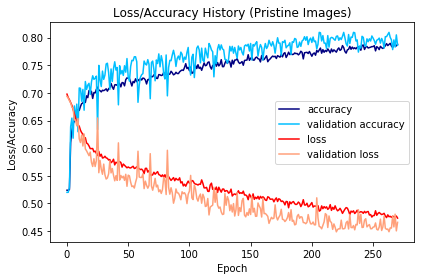

In [12]:
#plotting from history

#LOSS
loss=n['loss']
val_loss=n['val_loss']
acc=n['acc']
val_acc=n['val_acc']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='center right')

cm [[1114.  311.]
 [ 329. 1331.]]
cm_norm [[0.78175439 0.21824561]
 [0.19819277 0.80180723]]
AUC: 0.8647376875924752


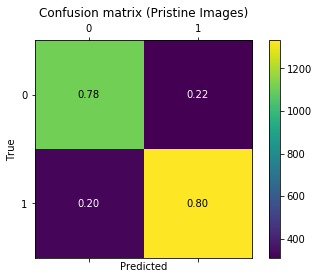

In [7]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET
# ------------------------------------------------------------------------------

# predict
prob = loaded_model.predict(x_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = metrics.confusion_matrix(y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=1)
auc = metrics.roc_auc_score(y_test, prob)
print("AUC:", auc)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix (Pristine Images)', y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

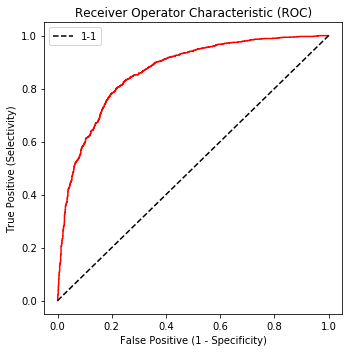

In [22]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()

In [7]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

# brier score
bs = brier_score_loss(y_test, prob)
print('Brier score: %f' % bs)

Accuracy: 0.792545
Precision: 0.810597
Recall: 0.801807
F1 score: 0.806178
Brier score: 0.148574


# Example images

In [ ]:
# seraching for examples
for i in range(len(y_test)):
    if (y_test[i] == 1 and pred[i,0] == 1): # and other y_test vs pered combinations TP=(1,1), FP=(0,1), TN=(0,0), FN=(1,0)
        print (i)
        print(y_test[i],pred[i])

In [8]:
#print output probabilities for the chosen TP, FP, TN, FN examples
print(prob[84],prob[1370],prob[2031],prob[3003]) # TP examples
print(prob[560],prob[1228],prob[2878],prob[3026]) # FP examples
print(prob[564],prob[1056],prob[2083],prob[3063]) # TN examples
print(prob[465],prob[1546],prob[2241],prob[3037]) # FN examples

[0.703352] [0.88274795] [0.929438] [0.86044]
[0.7674367] [0.5566581] [0.9244127] [0.6438459]
[0.2309299] [0.07827272] [0.05245843] [0.25679544]
[0.31270114] [0.41831633] [0.09127135] [0.44018817]


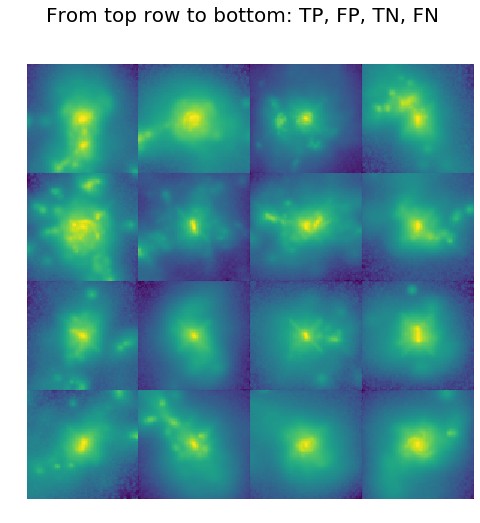

In [9]:
# plot examples
tp1 = x_test[84,1]
tp2 = x_test[1370,1]
tp3 = x_test[2031,1]
tp4 = x_test[3003,1]

fp1 = x_test[560,1]
fp2 = x_test[1228,1]
fp3 = x_test[2878,1]
fp4 = x_test[3026,1]

tn1 = x_test[564,1]
tn2 = x_test[1056,1]
tn3 = x_test[2083,1]
tn4 = x_test[3063,1]

fn1 = x_test[465,1]
fn2 = x_test[1546,1]
fn3 = x_test[2241,1]
fn4 = x_test[3037,1]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]

fig1=plt.figure(figsize=(8,8))

for i, image in enumerate(examples):
    fig1.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=20)
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='viridis', norm=LogNorm())
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Past and future merger subsamples

In [8]:
#make subsamples for plotting
list_past = []
list_future = []
list_nonmerger = []
for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_past.append(prob[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_future.append(prob[i])
    if y_sub_test[i,0]==0:
        list_nonmerger.append(prob[i])
past = np.stack(list_past)
future = np.stack(list_future)
non = np.stack(list_nonmerger)

print('TEST SET OF PRISTINE IMAGES SB00\n' 'Number of past mergers:',
      len(past) ,'\nNumber of future mergers:',
      len(future),'\nNumber of non-mergers:',len(non))

TEST SET OF PRISTINE IMAGES SB00
Number of past mergers: 1227 
Number of future mergers: 433 
Number of non-mergers: 1425


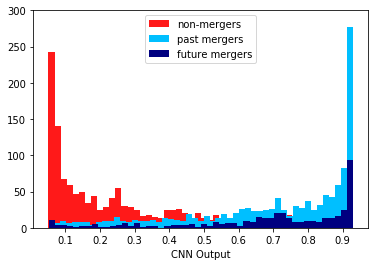

In [41]:
# plot histogram
bins = 50
plt.hist(non, bins, alpha=0.9, label='non-mergers', color='red')
plt.hist(past, bins, alpha=1, label='past mergers', color='deepskyblue')
plt.hist(future, bins, alpha=1, label='future mergers', color='navy')
plt.legend(loc='upper center')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.yticks(np.arange(0, 310, step=50))
plt.xlabel("CNN Output")
plt.show()

# Morphology study (Concentration and M20)

In [23]:
# subsamples for plotting
list_past_subid = []
list_future_subid = []
list_nonmerger_subid = []

cc_past_list = []
cc_future_list = []
cc_non_list = []

m20_past_list = []
m20_future_list = []
m20_non_list = []


for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_past_subid.append(subid_test[i])
        cc_past_list.append(cc_test[i])
        m20_past_list.append(m20_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_future_subid.append(subid_test[i])
        cc_future_list.append(cc_test[i])
        m20_future_list.append(m20_test[i])
    if y_sub_test[i,0]==0:
        list_nonmerger_subid.append(subid_test[i])
        cc_non_list.append(cc_test[i])
        m20_non_list.append(m20_test[i])
        
past_subid = np.stack(list_past_subid)
future_subid = np.stack(list_future_subid)
non_subid = np.stack(list_nonmerger_subid)

cc_past = np.stack(cc_past_list)
cc_future = np.stack(cc_future_list)
cc_non = np.stack(cc_non_list)

m20_past = np.stack(m20_past_list)
m20_future = np.stack(m20_future_list)
m20_non = np.stack(m20_non_list)

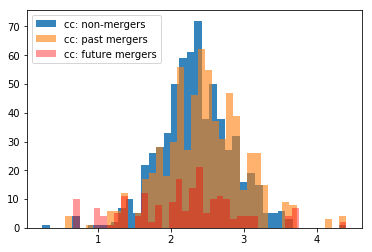

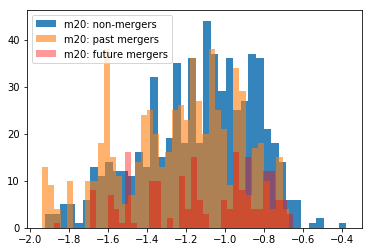

In [29]:
# concentration histogram for the three subgroups - past, future and non-mergers
bins = 40
plt.hist(cc_non, bins, alpha=0.9, label='cc: non-mergers')
plt.hist(cc_past, bins, alpha=0.6, label='cc: past mergers')
plt.hist(cc_future, bins, alpha=0.4, label='cc: future mergers', color='red')
plt.legend(loc='upper left')
plt.show()

# M20 histogram for the three subgroups - past, future and non-mergers
bins = 40
plt.hist(m20_non, bins, alpha=0.9, label='m20: non-mergers')
plt.hist(m20_past, bins, alpha=0.6, label='m20: past mergers')
plt.hist(m20_future, bins, alpha=0.4, label='m20: future mergers', color='red')
plt.legend(loc='upper left')
plt.show()

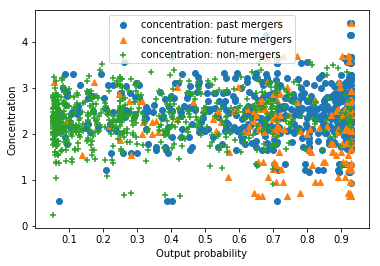

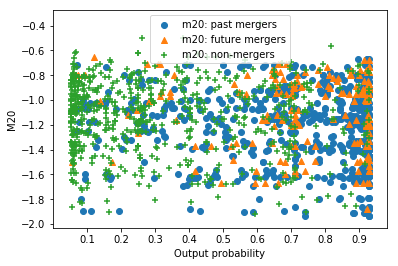

In [28]:
# concentration for the three subgroups - past, future and non-mergers
plt.scatter(past, cc_past, marker='o', label='concentration: past mergers')
plt.scatter(future, cc_future, marker='^', label='concentration: future mergers')
plt.scatter(non, cc_non, marker='+', label='concentration: non-mergers')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper center')
plt.xlabel('Output probability')
plt.ylabel('Concentration')
plt.show()

# M20 for the three subgroups - past, future and non-mergers
plt.scatter(past, m20_past, marker='o', label='m20: past mergers')
plt.scatter(future, m20_future, marker='^', label='m20: future mergers')
plt.scatter(non, m20_non, marker='+', label='m20: non-mergers')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper center')
plt.xlabel('Output probability')
plt.ylabel('M20')
plt.show()

# Morphology study (Stellar mass)

In [9]:
# subsamples for plotting
logM_past_list = []
logM_future_list = []
logM_non_list = []

for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        logM_past_list.append(logM_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        logM_future_list.append(logM_test[i])
    if y_sub_test[i,0]==0:
        logM_non_list.append(logM_test[i])
        
logM_past = np.stack(logM_past_list)
logM_future = np.stack(logM_future_list)
logM_non = np.stack(logM_non_list)

In [10]:
# subsamples for plotting, but only TPs (their stellar mass and the output probabilities)
prob_TP_list_past = []
prob_TP_list_future = []
logM_TP_list_past = []
logM_TP_list_future = []


for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1 and prob[i] > 0.5 :
        prob_TP_list_past.append(prob[i])
        logM_TP_list_past.append(logM_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0 and prob[i] > 0.5:
        prob_TP_list_future.append(prob[i])
        logM_TP_list_future.append(logM_test[i])
        
logM_TP_past = np.stack(logM_TP_list_past)
prob_TP_past = np.stack(prob_TP_list_past)

logM_TP_future = np.stack(logM_TP_list_future)
prob_TP_future = np.stack(prob_TP_list_future)


# subsamples for plotting, but only TNs (their stellar mass and the output probabilities)
prob_TN_list = []
logM_TN_list = []

for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==0 and y_sub_test[i,1]==0 and prob[i] < 0.5 :
        prob_TN_list.append(prob[i])
        logM_TN_list.append(logM_test[i])
logM_TN = np.stack(logM_TN_list)
prob_TN = np.stack(prob_TN_list)

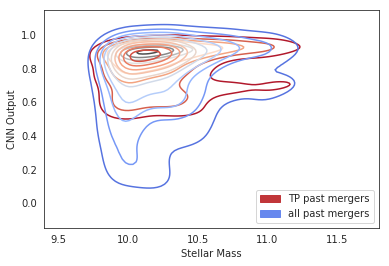

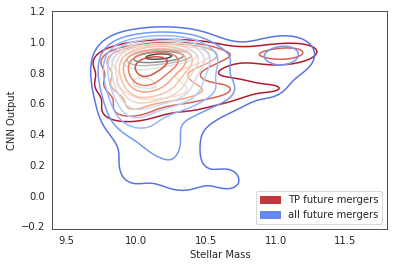

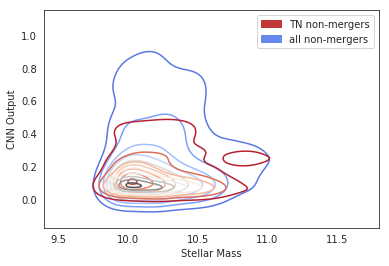

In [28]:
# Plot 2D histogram of the distribution of all past mergers vs TP past mergers 
#(stellar mass and the output probability)
sns.set_style("white")
plt.ylabel('CNN Output')
plt.xlabel('Stellar Mass')
plt.xlim(9.4, 11.8)
plt.xticks([9.5, 10, 10.5, 11, 11.5])
sns.kdeplot(logM_TP_past, prob_TP_past[:,0], cmap='RdGy', n_levels=10)
sns.kdeplot(logM_past, past[:,0], cmap= 'coolwarm', n_levels=10)

r = sns.color_palette("RdGy")[0]
b = sns.color_palette("coolwarm")[0]

red_patch = mpatches.Patch(color=r, label='TP past mergers')
blue_patch = mpatches.Patch(color=b, label='all past mergers')
plt.legend(handles=[red_patch,blue_patch],loc='lower right')
plt.show()


# Plot 2D histogram of the distribution of all future mergers vs TP future mergers 
#(stellar mass and the output probability)
sns.set_style("white")
plt.ylabel('CNN Output')
plt.xlabel('Stellar Mass')
plt.xlim(9.4, 11.8)
plt.xticks([9.5, 10, 10.5, 11, 11.5])
sns.kdeplot(logM_TP_future, prob_TP_future[:,0], cmap="RdGy",  n_levels=10)
sns.kdeplot(logM_future, future[:,0], cmap="coolwarm", n_levels=10)

r = sns.color_palette("RdGy")[0]
b = sns.color_palette("coolwarm")[0]

red_patch = mpatches.Patch(color=r, label='TP future mergers')
blue_patch = mpatches.Patch(color=b, label='all future mergers')
plt.legend(handles=[red_patch,blue_patch],loc='lower right')
plt.show()


# Plot 2D histogram of the distribution of all non-mergers vs TN non-mergers 
#(stellar mass and the output probability)
sns.set_style("white")
plt.ylabel('CNN Output')
plt.xlabel('Stellar Mass')
plt.xlim(9.4, 11.8)
plt.xticks([9.5, 10, 10.5, 11, 11.5])
sns.kdeplot(logM_non, non[:,0],n_levels=10, cmap="coolwarm")
sns.kdeplot(logM_TN, prob_TN[:,0],n_levels=10, cmap="RdGy")

r = sns.color_palette("RdGy")[0]
b = sns.color_palette("coolwarm")[0]

red_patch = mpatches.Patch(color=r, label='TN non-mergers')
blue_patch = mpatches.Patch(color=b, label='all non-mergers')
plt.legend(handles=[red_patch,blue_patch],loc='upper right')
plt.show()

# Activation layers

In [10]:
# Extracts the outputs of all layers except the input layer
layer_outputs = [layer.output for layer in loaded_model.layers[1:]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs) 

# returns the values of the layer activations in the original model
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(x_test) 

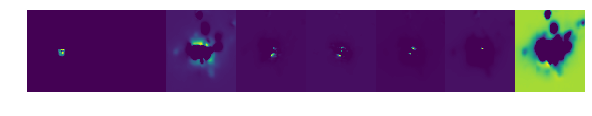

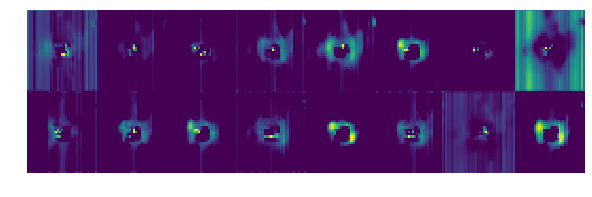

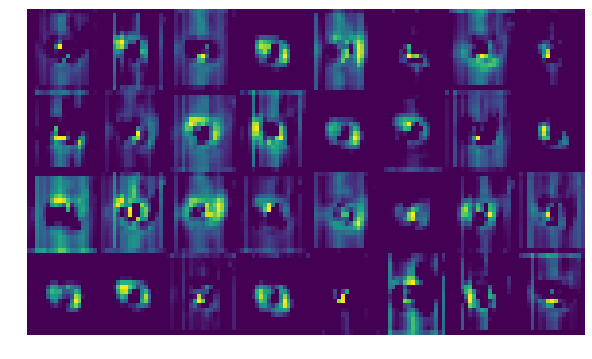

In [40]:
# activation maps for all 8 filters in the first convolutional layer
fig1=plt.figure(figsize=(10,1.5))  
for i in range(8):
    plt.subplot(1, 8, i + 1)
    layer_activation = activations[0]
    plt.imshow(layer_activation[1649,i, :, :], cmap='viridis',aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

# activation maps for all 16 filters in the second convolutional layer    
fig2=plt.figure(figsize=(10,3))  
for i in range(16):
    plt.subplot(2, 8, i + 1)
    layer_activation = activations[4]
    plt.imshow(layer_activation[1649,i, :, :], cmap='viridis',aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    
# activation maps for all 32 filters in the third convolutional layer
fig3=plt.figure(figsize=(10,6))  
for i in range(32):
    plt.subplot(4, 8, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649,i, :, :], cmap='viridis',aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

# Grad-CAM

In [37]:
# largest output probabilities
example_i_TP=[]
example_i_FP=[]
example_i_TN=[]
example_i_FN=[]

for i in range(len(prob)):
    if prob[i] > 0.90 and y_test[i]==1:
        example_i_TP.append(i) 
    if prob[i] > 0.80 and y_test[i]==0:
        example_i_FP.append(i) 
        
        
for i in range(len(prob)):
    if prob[i] < 0.1 and y_test[i]==0:
        example_i_TN.append(i) 
    if prob[i] < 0.15 and y_test[i]==1:
        example_i_FN.append(i) 
        
        
# lowest output probabilities
bad_example_i_TP=[]
bad_example_i_FP=[]
bad_example_i_TN=[]
bad_example_i_FN=[]

for i in range(len(prob)):
    if 0.5 < prob[i] < 0.55 and y_test[i]==1:
        bad_example_i_TP.append(i) 
    if 0.5 < prob[i] < 0.58 and y_test[i]==0:
        bad_example_i_FP.append(i) 
        
        
for i in range(len(prob)):
    if 0.44 < prob[i] < 0.5 and y_test[i]==0:
        bad_example_i_TN.append(i) 
    if 0.44 < prob[i] < 0.5 and y_test[i]==1:
        bad_example_i_FN.append(i) 

In [35]:
# set channel_first data format in Keras backend in order for grad-CAM to work properly
K.set_image_data_format('channels_first')

# find the last convolutional layer
penultimate_layer = utils.find_layer_idx(loaded_model, 'conv2d_3')
class_idx = 0 # choose the class position in the output layer, here 0 since the output has just one dimention
layer_idx = -1 # location of the output layer

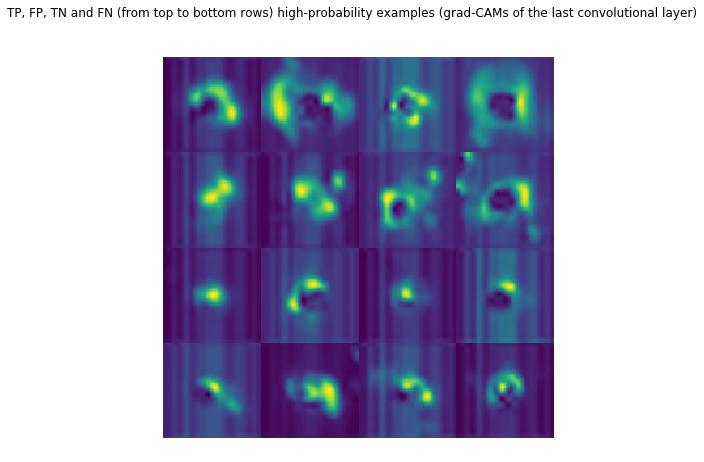

In [38]:
# make a list of four TP, FP, TN and FN high-probability examples 
example_list=[example_i_TP[22],example_i_TP[2],example_i_TP[4],example_i_TP[5],
             example_i_FP[1],example_i_FP[7],example_i_FP[3],example_i_FP[4],
             example_i_TN[2],example_i_TN[3],example_i_TN[11],example_i_TN[5],
             example_i_FN[1],example_i_FN[2],example_i_FN[15],example_i_FN[5]]

fig1=plt.figure(figsize=(7,7))
fig1.suptitle("TP, FP, TN and FN (from top to bottom rows) high-probability examples (grad-CAMs of the last convolutional layer)")

for i in range(16):
    grads = visualize_cam(loaded_model, layer_idx, filter_indices=0, 
                              seed_input=x_test[example_list[i]], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier='guided')
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    
    plt.imshow(grads, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

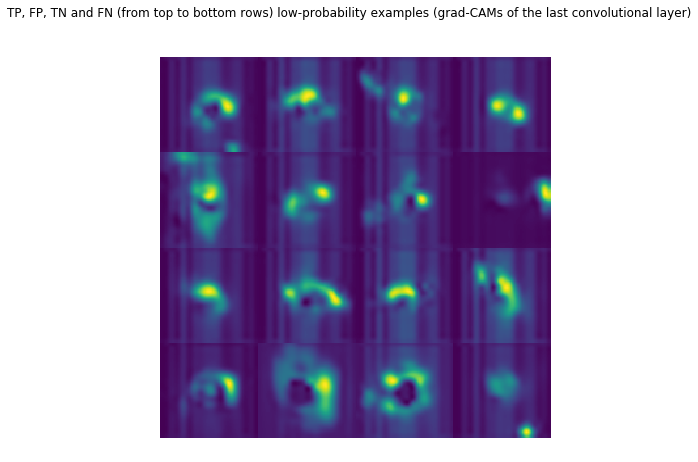

In [39]:
# make a list of four TP, FP, TN and FN low-probability examples 
bad_example_list=[bad_example_i_TP[22],bad_example_i_TP[2],bad_example_i_TP[4],bad_example_i_TP[5],
             bad_example_i_FP[1],bad_example_i_FP[7],bad_example_i_FP[3],bad_example_i_FP[4],
             bad_example_i_TN[13],bad_example_i_TN[20],bad_example_i_TN[11],bad_example_i_TN[5],
             bad_example_i_FN[1],bad_example_i_FN[7],bad_example_i_FN[15],bad_example_i_FN[5]]

fig1=plt.figure(figsize=(7,7))
fig1.suptitle("TP, FP, TN and FN (from top to bottom rows) low-probability examples (grad-CAMs of the last convolutional layer)")

for i in range(16):
    grads = visualize_cam(loaded_model, layer_idx, filter_indices=0, 
                              seed_input=x_test[bad_example_list[i]], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier='guided')
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    
    plt.imshow(grads, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Bootstraping

In [32]:
# Bootstraping is used to show errors of different clasificaiton scoring methods. 
# We make 1000 bootstraping resamples and recalculate AUC, accuracy etc.
# Then we find 95% CI for these values.

y_pred = pred # output class 0 or 1
y_prob = prob # output probability between 0 and 1
y_true = y_test # true class 0 or 1

n_bootstraps = 1000
rng_seed = 3  # controls reproducibility
bootstrapped_auc = []
bootstrapped_accuracy = []
bootstrapped_precision = []
bootstrapped_recall = []
bootstrapped_f1 = []
bootstrapped_brier = []
bootstrapped_fpr = []
bootstrapped_tpr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_prob) - 1, len(y_prob))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score_auc = roc_auc_score(y_true[indices], y_prob[indices])
    bootstrapped_auc.append(score_auc)
   
    score_acc = accuracy_score(y_true[indices], y_pred[indices])
    bootstrapped_accuracy.append(score_acc)
    
    score_precision = precision_score(y_true[indices], y_pred[indices])
    bootstrapped_precision.append(score_precision)
    
    score_recall = recall_score(y_true[indices], y_pred[indices])
    bootstrapped_recall.append(score_recall)
    
    score_f1 = f1_score(y_true[indices], y_pred[indices])
    bootstrapped_f1.append(score_f1)
    
    score_brier = brier_score_loss(y_true[indices], y_prob[indices])
    bootstrapped_brier.append(score_brier)
    
    fpr_score, tpr_score, thresholds_score = metrics.roc_curve(y_true[indices], y_prob[indices], pos_label=1)
    bootstrapped_fpr.append(fpr_score)
    bootstrapped_tpr.append(tpr_score)

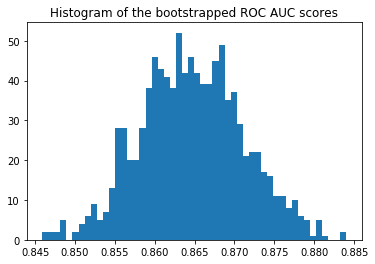

In [13]:
# we can plot histograms to see the bootstraped values
# change to "bootstrapped_accuracy,bootstrapped_precision,bootstrapped_recall,
# bootstrapped_f1,bootstrapped_brier", for other histograms
plt.hist(bootstrapped_auc, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [34]:
sorted_auc = np.array(bootstrapped_auc)
sorted_acc = np.array(bootstrapped_accuracy)
sorted_precision = np.array(bootstrapped_precision)
sorted_recall = np.array(bootstrapped_recall)
sorted_f1 = np.array(bootstrapped_f1)
sorted_brier = np.array(bootstrapped_brier)

sorted_auc.sort()
sorted_acc.sort()
sorted_precision.sort()
sorted_recall.sort()
sorted_f1.sort()
sorted_brier.sort()

# Computing the lower and upper bound of the 95% confidence interval
confidence_lower_auc = sorted_auc[int(0.025 * len(sorted_auc))]
confidence_upper_auc = sorted_auc[int(0.975 * len(sorted_auc))]

confidence_lower_acc = sorted_acc[int(0.025 * len(sorted_acc))]
confidence_upper_acc = sorted_acc[int(0.975 * len(sorted_acc))]
                                 
confidence_lower_precision = sorted_precision[int(0.025 * len(sorted_precision))]
confidence_upper_precision = sorted_precision[int(0.975 * len(sorted_precision))]
                                 
confidence_lower_recall = sorted_recall[int(0.025 * len(sorted_recall))]
confidence_upper_recall = sorted_recall[int(0.975 * len(sorted_recall))]
                                       
confidence_lower_f1 = sorted_f1[int(0.025 * len(sorted_f1))]
confidence_upper_f1 = sorted_f1[int(0.975 * len(sorted_f1))]
                                 
confidence_lower_brier = sorted_brier[int(0.025 * len(sorted_brier))]
confidence_upper_brier = sorted_brier[int(0.975 * len(sorted_brier))]


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_prob)))
print("95% Confidence interval for the AUC score: [{:0.3} - {:0.3}]".format(
    confidence_lower_auc, confidence_upper_auc))
print("95%CI AUC errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_auc - roc_auc_score(y_true, y_prob), 
    confidence_upper_auc - roc_auc_score(y_true, y_prob)))

print("Original Accuracy: {:0.3f}".format(accuracy_score(y_true, y_pred)))
print("95% Confidence interval for the Accuracy: [{:0.3} - {:0.3}]".format(
    confidence_lower_acc, confidence_upper_acc))
print("95%CI Accuracy errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_acc - accuracy_score(y_true, y_pred), 
    confidence_upper_acc - accuracy_score(y_true, y_pred)))

print("Original Precision: {:0.3f}".format(precision_score(y_true, y_pred)))
print("95% Confidence interval for the Precision: [{:0.3} - {:0.3}]".format(
    confidence_lower_precision, confidence_upper_precision))
print("95%CI Precision errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_precision - precision_score(y_true, y_pred), 
    confidence_upper_precision - precision_score(y_true, y_pred)))

print("Original Recall: {:0.3f}".format(recall_score(y_true, y_pred)))
print("95% Confidence interval for the Recall: [{:0.3} - {:0.3}]".format(
    confidence_lower_recall, confidence_upper_recall))
print("95%CI Recall errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_recall - recall_score(y_true, y_pred), 
    confidence_upper_recall - recall_score(y_true, y_pred)))

print("Original F1 score: {:0.3f}".format(f1_score(y_true, y_pred)))
print("95% Confidence interval for the F1 score: [{:0.3} - {:0.3}]".format(
    confidence_lower_f1, confidence_upper_f1))
print("95%CI F1 score errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_f1 - f1_score(y_true, y_pred), 
    confidence_upper_f1 - f1_score(y_true, y_pred)))

print("Original Brier score: {:0.3f}".format(brier_score_loss(y_true, y_prob)))
print("95% Confidence interval for the Brier score: [{:0.3} - {:0.3}]".format(
    confidence_lower_brier, confidence_upper_brier))
print("95%CI Brier score errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_brier - brier_score_loss(y_true, y_prob), 
    confidence_upper_brier - brier_score_loss(y_true, y_prob)))

Original ROC area: 0.865
95% Confidence interval for the AUC score: [0.852 - 0.878]
95%CI AUC errors are: [-0.0125 , 0.0129]
Original Accuracy: 0.793
95% Confidence interval for the Accuracy: [0.778 - 0.807]
95%CI Accuracy errors are: [-0.0143 , 0.0143]
Original Precision: 0.811
95% Confidence interval for the Precision: [0.792 - 0.828]
95%CI Precision errors are: [-0.0184 , 0.0174]
Original Recall: 0.802
95% Confidence interval for the Recall: [0.78 - 0.821]
95%CI Recall errors are: [-0.0219 , 0.0195]
Original F1 score: 0.806
95% Confidence interval for the F1 score: [0.791 - 0.82]
95%CI F1 score errors are: [-0.0156 , 0.0139]
Original Brier score: 0.149
95% Confidence interval for the Brier score: [0.141 - 0.156]
95%CI Brier score errors are: [-0.00744 , 0.00734]


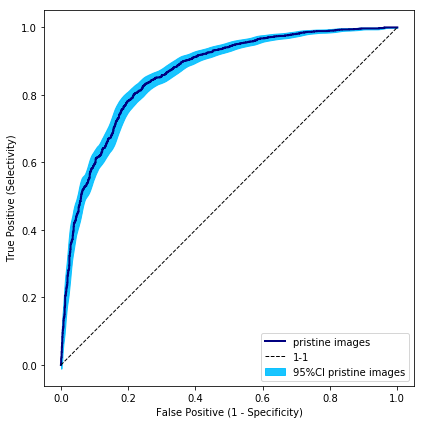

In [55]:
# We can also find 95%CI (in vertical direction) for the ROC curve

tprs = []
base_fpr = np.linspace(0, 1, 1001)

for i in range(len(bootstrapped_fpr)):  
    tpr1 = interp(base_fpr, bootstrapped_fpr[i], bootstrapped_tpr[i])
    tpr1[0] = 0.0
    tprs.append(tpr1)

tprs = np.array(tprs)
mean = tprs.mean(axis=0) # mean tpr
std = tprs.std(axis=0) # standard deviation of tpr

# 95%CI can be calculated as:
tprs_upper_95 = mean + 1.96*std  # 1.96 is z-score for 95%CI
tprs_lower_95 = mean - 1.96*std


# Plots ROC curve with 95%CI in the vertical direction
figsize=(6,6)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]

prist = plt.plot(fpr, tpr, 'navy', linewidth=2, label='pristine images')
prist_fill = plt.fill_between(base_fpr, tprs_lower_95, tprs_upper_95, color='deepskyblue', alpha=0.9, label='95%CI pristine images')
line = plt.plot(x_onetoone, y_onetoone, 'k--',linewidth=1, label="1-1")


plt.legend(loc='lower right')
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()